# **<center><font color="blue">Human Action Recognition in Videos using TensorFlow (CNN + LSTM)</font></center>**

## **References.**

> [**YouTube Tutorial**](https://www.youtube.com/watch?v=QmtSkq3DYko)

> [**Download Dataset**](https://onedrive.live.com/?authkey=%21AKoslvNCgjyfWqE&id=8007B9DE38BDCD17%21165696&cid=8007B9DE38BDCD17)


## **Project Outline.**

- **`Step 1:` Download and Visualize the Data with its Labels.**

- **`Step 2:` Preprocess the Dataset.**

- **`Step 3:` Split the Data into Train and Test Set.**

- **`Step 4:` Implement the ConvLSTM Approach.**

    - **`Step 4.1:` Construct the Model.**
    
    - **`Step 4.2:` Train the Model.**
    
    - **`Step 4.3:` Plot Model's Loss & Accuracy Curves.**

- **`Step 5:` Implement the LRCN Approach.**
 
    - **`Step 5.1:` Construct the Model.**
    
    - **`Step 5.2:` Train the Model.**
    
    - **`Step 5.3:` Plot Model's Loss & Accuracy Curves.**
    
- **`Step 6:` Test the Best Performing Model on YouTube Videos.**

In [ ]:
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git

In [ ]:
# Import Library.
import os
import cv2
import pafy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from moviepy.editor import *
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

*Set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.*

In [ ]:
seed_constant = 10
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Step 1: Download and Visualize the Data with its Labels.**

In the first step, we will download and visualize the data along with the labels to get an idea about what we will be dealing with. We will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of several realistic videos taken from youtube, which differentiates this dataset from most of the other available action recognition datasets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories.
*   **`25`** Groups of Videos per Action Category.
*   **`133`** Average Videos per Action Category.
*   **`199`** Average Number of Frames per Video.
*   **`320`** Average Frames Width per Video.
*   **`240`** Average Frames Height per Video.
*   **`26`** Average Frames Per Seconds per Video.

*Let's download and extract the dataset.*

In [ ]:
# Download the UCF50 Dataset.
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset.
!unrar x UCF50.rar

***For visualization, we pick `20` random categories from the dataset and a random video from each selected category and visualize the first frame of the selected videos with their associated labels. This way, we'll be able to represent a subset (`20` random videos ) of the dataset.***

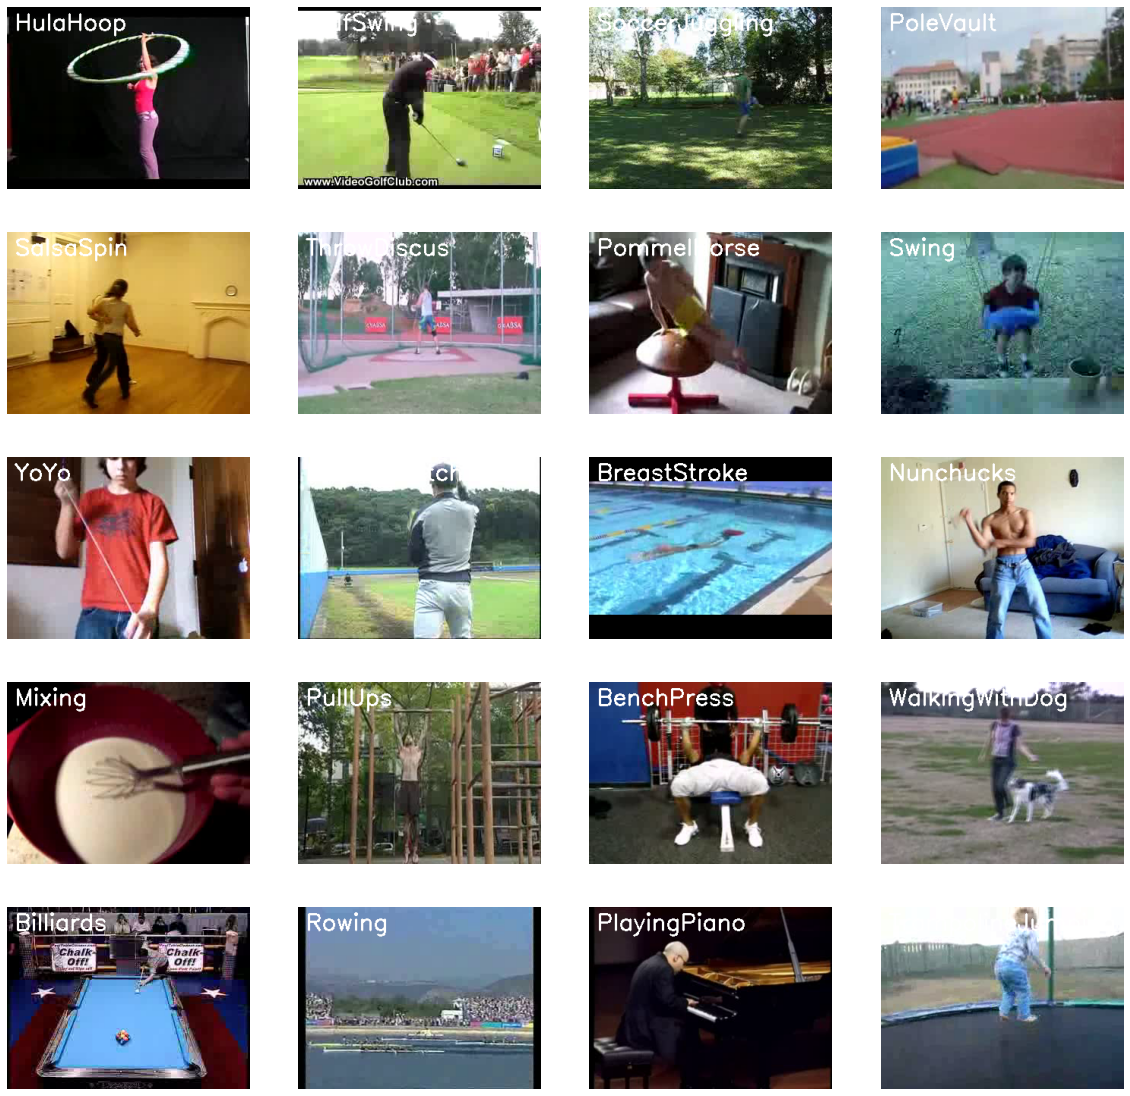

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in the UCF50 Dataset.
all_classes_names = os.listdir("UCF50")

# Generate a list of 20 random values. The values will be between 0-50, where 50 is the total number of classes in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterate through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f"UCF50/{selected_class_Name}")

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(
        f"UCF50/{selected_class_Name}/{selected_video_file_name}"
    )

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(
        rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2
    )

    # Display the Frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis("off")

## **Step 2: Preprocess the Dataset.**

In this step, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalize the data to the range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`**, and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **Create a Function to Extract, Resize & Normalize Frames.**

We implement a function **`frames_extraction()`** that creates a list containing the resized and normalized frames of a video whose path gets passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [ ]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    """

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the frame from the video.
        success, frame = video_reader.read()

        # If Video Frame is unsuccessfully read, then break the loop.
        if not success:
            break

        # Resize the Frame to a fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it by 255 so that each pixel value lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list.
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **Create a Function for Dataset Creation.**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    """
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    """

    # Declare Empty Lists to store the features, labels, and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterate through all the classes mentioned in the `CLASSES_LIST`.
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data gets extracted.
        print(f"Extracting Data of Class: {class_name}")

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Convert the list to NumPy arrays.
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

*Now we will utilize the function **`create_dataset()`** to extract the data of the selected classes and create the required dataset.*

In [ ]:
# Create the Dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
# Using Keras's `to_categorical()` method to convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = to_categorical(labels)

## **Step 3: Split the Data into Train and Test Set.**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.25,
    shuffle=True,
    random_state=seed_constant,
)

## **Step 4: Implement the ConvLSTM Approach.**

In this step, we will implement a combination of **ConvLSTM** cells. A **ConvLSTM** cell is a variant of an **LSTM** network that contains convolutions operations inside the network. It is an LSTM with convolution embedded in the architecture, making it capable of identifying spatial features of the data while keeping into account the temporal relation.

![ConvLSTM.png](https://miro.medium.com/max/942/1*u8neecA4w6b_F1NgnyPP0Q.png)

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input. Hence an LSTM is incompatible with modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015) to learn more about this architecture.


### **Step 4.1: Construct the Model.**

To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers gets flattened in the end and is passed to the **`Dense`** layer with softmax activation, which outputs the probability of each action category.

We also used the **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent overfitting the model on the data. The architecture is simple and has a small number of trainable parameters. It is because we only deal with a small subset of the dataset, which does not require a large-scale model.

In [ ]:
def convlstm_model():
    """
    This function will construct the required ConvLSTM model.
    Returns:
        model: It is the required constructed ConvLSTM model.
    """
    model = Sequential()

    # Define the Model Architecture.
    model.add(
        ConvLSTM2D(
            filters=8,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
            input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        )
    )
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=8,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(
        ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last")
    )

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    # Compile the Model.
    model.compile(
        loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
    )

    return model

In [ ]:
# We will utilize the function `convlstm_model()` to construct the required ConvLSTM Model.
convlstm = convlstm_model()

# Model Summary.
convlstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 8)     3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 8)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 8)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     4640      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

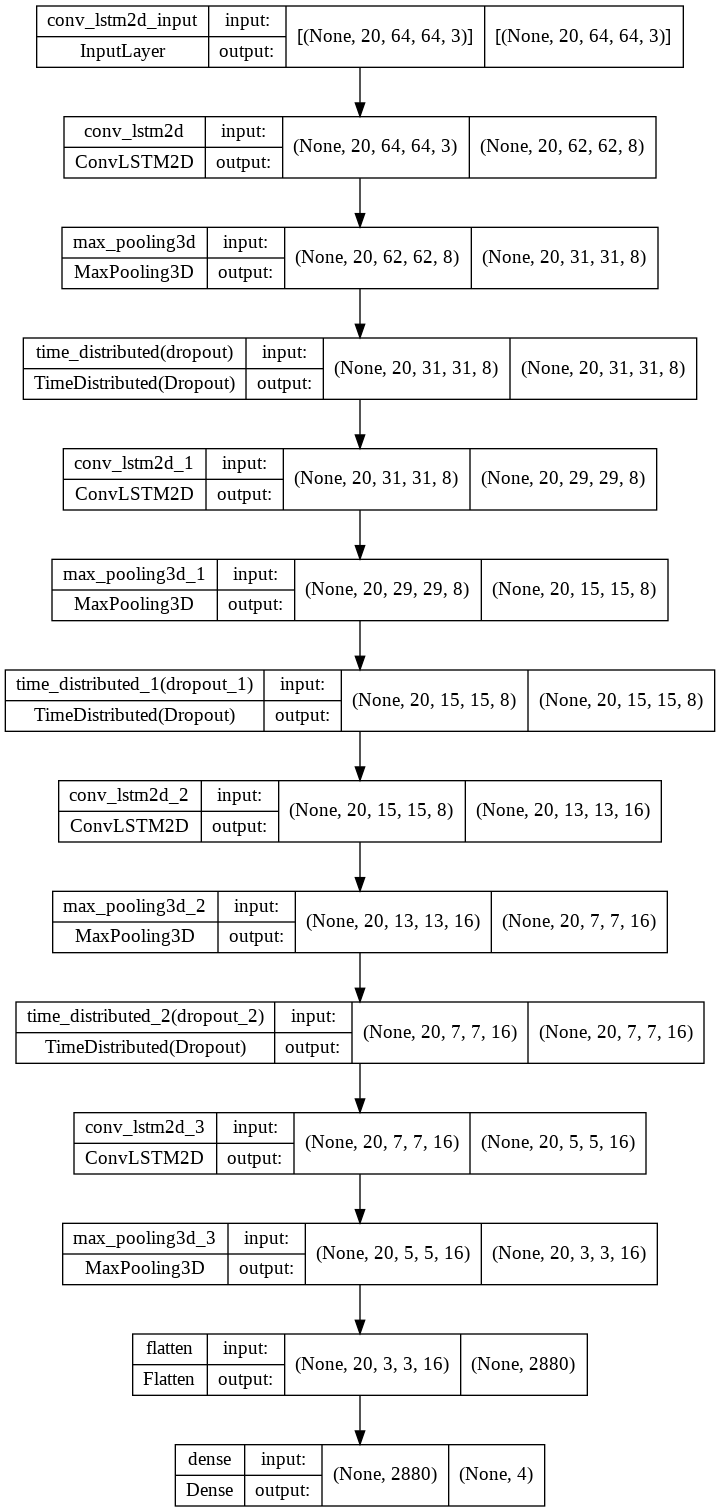

In [ ]:
# Plot the Structure of the Constructed Model.
plot_model(convlstm, to_file="convlstm_model_plot.png", show_shapes=True, show_layer_names=True)

### **Step 4.2: Train the Model.**

In [ ]:
# Fit the Model.
history = convlstm.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
    ],
)

Epoch 1/50
37/37 [==============================] - 42s 572ms/step - loss: 1.3786 - accuracy: 0.2671 - val_loss: 1.3825 - val_accuracy: 0.2603
Epoch 2/50
37/37 [==============================] - 21s 559ms/step - loss: 1.3824 - accuracy: 0.2842 - val_loss: 1.3735 - val_accuracy: 0.3151
Epoch 3/50
37/37 [==============================] - 20s 534ms/step - loss: 1.3433 - accuracy: 0.3390 - val_loss: 1.2819 - val_accuracy: 0.4384
Epoch 4/50
37/37 [==============================] - 20s 546ms/step - loss: 1.2056 - accuracy: 0.5000 - val_loss: 1.0370 - val_accuracy: 0.5753
Epoch 5/50
37/37 [==============================] - 20s 539ms/step - loss: 0.9888 - accuracy: 0.5959 - val_loss: 0.8990 - val_accuracy: 0.6164
Epoch 6/50
37/37 [==============================] - 20s 542ms/step - loss: 0.8356 - accuracy: 0.6541 - val_loss: 0.7546 - val_accuracy: 0.6849
Epoch 7/50
37/37 [==============================] - 20s 539ms/step - loss: 0.6464 - accuracy: 0.7534 - val_loss: 0.6623 - val_accuracy: 0.7534

In [ ]:
# Save the Model.
convlstm.save("convlstm.h5")

### **Step 4.3: Plot Model's Loss & Accuracy Curves.**

We create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps, so now we have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object, containing a record of training and validation loss values and metrics values at successive epochs.
        metric_name_1:          The first metric to be plotted in the graph.
        metric_name_2:          The second metric to be plotted in the graph.
        plot_name:              The title of the graph.
    """

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object to be used as the x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, "blue", label=metric_name_1)
    plt.plot(epochs, metric_value_2, "red", label=metric_name_2)

    # Add the title to the Plot.
    plt.title(str(plot_name))

    # Add a legend to the Plot.
    plt.legend()

*We will utilize the function **`plot_metric()`** created above to visualize and understand the metrics.*

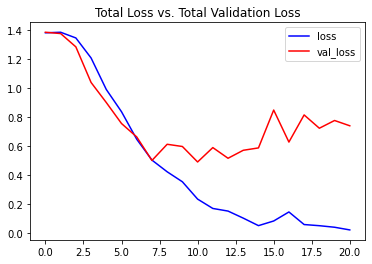

In [ ]:
# Visualize the training and validation loss metrics.
plot_metric(history, "loss", "val_loss", "Total Loss vs. Total Validation Loss")

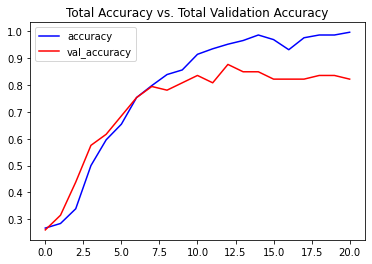

In [ ]:
# Visualize the training and validation accuracy metrics.
plot_metric(history, "accuracy", "val_accuracy", "Total Accuracy vs. Total Validation Accuracy")

## **Step 5: Implement the LRCN Approach.**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach is to use CNN and LSTM models trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be fine-tuned. And finally, the LSTM model can then use the features extracted by CNN to predict the action performed in the video.

But in this solution, we implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers capture the spatial feature extraction from the frames, and then the extracted spatial features are fed to the LSTM layer(s) at each time-steps for temporal sequence modeling. This way, the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

![LRCN.png](https://kobiso.github.io//assets/images/lrcn_tasks.png)

You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389) by Jeff Donahue (CVPR 2015) to learn more about this architecture.

We also used the [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)`, which is very beneficial as it allows to input the whole video into the model in a single shot.

### **Step 5.1: Construct the Model.**

To implement the LRCN architecture, we will use time-distributed **`Conv2D`** layers followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will then be flattened using the  **`Flatten`** layer and finally gets passed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def LRCN_model():
    """
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    """
    model = Sequential()

    # Define the Model Architecture.
    model.add(
        TimeDistributed(
            Conv2D(16, (3, 3), padding="same", activation="relu"),
            input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        )
    )
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    # Compile the Model.
    model.compile(
        loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
    )

    return model

In [ ]:
# We will utilize the function `LRCN_model()` to construct the required LRCN Model.
lrcn = LRCN_model()

# Model Summary.
lrcn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

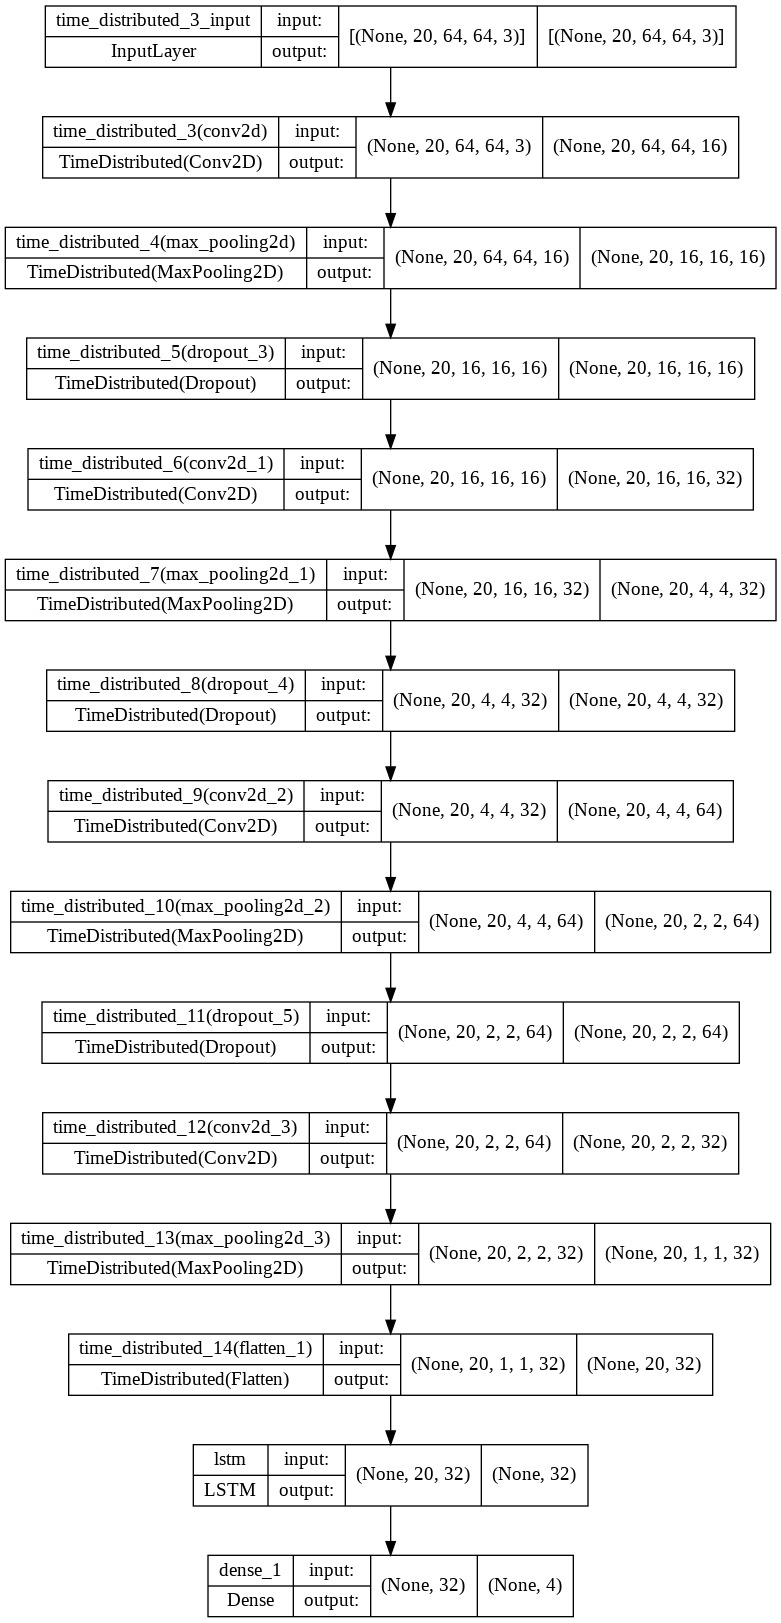

In [ ]:
# Plot the Structure of the Constructed Model.
plot_model(lrcn, to_file="LRCN_model_plot.png", show_shapes=True, show_layer_names=True)

### **Step 5.2: Train the Model.**

In [ ]:
# Fit the Model.
history = lrcn.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    ],
)

Epoch 1/100
37/37 [==============================] - 5s 37ms/step - loss: 1.3868 - accuracy: 0.2500 - val_loss: 1.3655 - val_accuracy: 0.3973
Epoch 2/100
37/37 [==============================] - 1s 18ms/step - loss: 1.3613 - accuracy: 0.3322 - val_loss: 1.3535 - val_accuracy: 0.4110
Epoch 3/100
37/37 [==============================] - 1s 17ms/step - loss: 1.3197 - accuracy: 0.4075 - val_loss: 1.2607 - val_accuracy: 0.3836
Epoch 4/100
37/37 [==============================] - 1s 16ms/step - loss: 1.2087 - accuracy: 0.4897 - val_loss: 1.0910 - val_accuracy: 0.6301
Epoch 5/100
37/37 [==============================] - 1s 16ms/step - loss: 1.0830 - accuracy: 0.5445 - val_loss: 1.2384 - val_accuracy: 0.4932
Epoch 6/100
37/37 [==============================] - 1s 16ms/step - loss: 0.9889 - accuracy: 0.5514 - val_loss: 0.9177 - val_accuracy: 0.6164
Epoch 7/100
37/37 [==============================] - 1s 16ms/step - loss: 0.8567 - accuracy: 0.6233 - val_loss: 0.9794 - val_accuracy: 0.5616
Epoch 

In [ ]:
# Save the Model.
lrcn.save("lrcn.h5")

### **Step 5.3: Plot Model's Loss & Accuracy Curves.**

*We will utilize the function **`plot_metric()`** created above to visualize and understand the training and validation metrics of this model.*

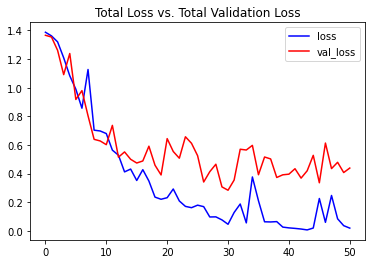

In [ ]:
# Visualize the training and validation loss metrics.
plot_metric(history, "loss", "val_loss", "Total Loss vs. Total Validation Loss")

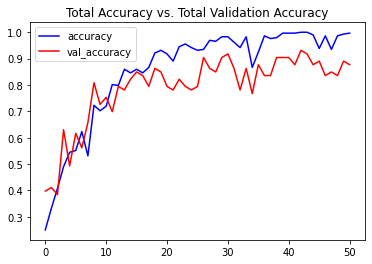

In [ ]:
# Visualize the training and validation accuracy metrics.
plot_metric(history, "accuracy", "val_accuracy", "Total Accuracy vs. Total Validation Accuracy")

## **Step 6: Test the Best Performing Model on YouTube Videos.**

*From the results, it seems that the LRCN model performed significantly well for a small number of classes. So in this step, we will put the `LRCN` model to test on some YouTube videos.*

### **Create a Function to Download YouTube Videos.**

We implement a function **`download_youtube_videos()`** to download the YouTube videos first by using the **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded YouTube video.
    """

    # Create a video object which contains useful information about the video.
    video = pafy.new(youtube_video_url)

    # Retrieve the title of the video.
    title = video.title

    # Get the best available quality object for the video.
    video_best = video.getbest()

    # Construct the output file path.
    output_file_path = f"{output_directory}/{title}.mp4"

    # Download the YouTube video at the best available quality and store it on the constructed path.
    video_best.download(filepath=output_file_path, quiet=True)

    # Return the video title.
    return title

### **Download a Test Video.**

*We utilize the function **`download_youtube_videos()`** to download a YouTube video on which the `LRCN` model will be tested.*

In [ ]:
# Make the output directory if it does not exist.
test_videos_directory = "test_videos"
os.makedirs(test_videos_directory, exist_ok=True)

# Download a YouTube Video.
video_title = download_youtube_videos(
    "https://www.youtube.com/watch?v=8u0qjmHIOcE", test_videos_directory
)

# Get the YouTube Video path we just downloaded.
input_video_file_path = f"{test_videos_directory}/{video_title}.mp4"

### **Create a Function To Perform Action Recognition on Videos.**

*We implement a function **`predict_on_video()`** that will read a video frame by frame from the path passed in as an argument and will perform action recognition on the video and save the results.*

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    """
    This function will perform action recognition on a video using the LRCN model.
    Args:
        video_file_path:  The path of the video is stored in the disk on which the action recognition is to be performed.
        output_file_path: The path where the output video with the predicted action being performed overlayed will be stored.
        SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    """

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter object to store the output video on the disk.
    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc("M", "P", "4", "V"),
        video_reader.get(cv2.CAP_PROP_FPS),
        (original_video_width, original_video_height),
    )

    # Declare a Queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ""

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the Frame.
        ok, frame = video_reader.read()

        # If the frame is not read properly, then break the loop.
        if not ok:
            break

        # Resize the frame to fixed dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it by 255 so that each pixel value lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue is equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = lrcn.predict(
                np.expand_dims(frames_queue, axis=0)
            )[0]

            # Get the index of class with the highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write the predicted class name on top of the frame.
        cv2.putText(
            frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2
        )

        # Write the frame into the disk using the VideoWriter object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **Perform Action Recognition on the Test Video.**

*We utilize the function **`predict_on_video()`** created above to perform action recognition on the test video that we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.*

In [ ]:
# Construct the output video path.
output_video_file_path = (
    f"{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4"
)

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(
    output_video_file_path, audio=False, target_resolution=(300, None)
).ipython_display()

### **Create a Function To Perform a Single Prediction on Videos.**

We implement a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the **`LRCN`** model. This approach is really useful when we are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    """
    This function will perform a single action recognition prediction on a video using the LRCN model.
    Args:
        video_file_path: The path of the video is stored in the disk on which the action recognition is to be performed.
        SEQUENCE_LENGTH: The fixed number of frames of a video can be passed to the model as one sequence.
    """

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ""

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate the number of times equal to the fixed length of the sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # If the frame is not read properly, then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it by 255 so that each pixel value, then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the pre-processed frame into the frames list.
        frames_list.append(normalized_frame)

    # Passing the pre-processed frames to the model and getting the predicted probabilities.
    predicted_labels_probabilities = lrcn.predict(np.expand_dims(frames_list, axis=0))[0]

    # Get the index of class with the highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f"Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}")

    # Release the VideoCapture object.
    video_reader.release()

### **Perform Single Prediction on a Test Video.**

*We utilize the function **`predict_single_action()`** to perform a single prediction on a complete YouTube test video that we will download using the function **`download_youtube_videos()`**, which we had created above.*

In [ ]:
# Download the YouTube video.
video_title = download_youtube_videos(
    "https://youtu.be/fc3w827kwyA", test_videos_directory
)

# Construct the input YouTube video path.
input_video_file_path = f"{test_videos_directory}/{video_title}.mp4"

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the Input Video.
VideoFileClip(
    input_video_file_path, audio=False, target_resolution=(300, None)
).ipython_display(maxduration=300)